# Solutions -- Tutorial 01: Introduction to Panel VAR Models

This notebook contains **complete solutions** for all exercises in `01_var_introduction.ipynb`.

**Instructions:** Attempt the exercises yourself before consulting these solutions. Each exercise section below reproduces the problem statement followed by a full, working solution.

---

## Exercises Covered

| Exercise | Topic | Difficulty |
|----------|-------|------------|
| 1 | Different Lag Orders | Easy |
| 2 | Covariance Specifications | Medium |
| 3 | Adding an Exogenous Variable | Medium |
| 4 | Subset Analysis: Group A vs. Group B | Hard |

In [1]:
# ============================================================
# Setup
# ============================================================
import sys
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
np.random.seed(42)
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path('../../../').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

sys.path.insert(0, '../utils')

from panelbox.var import PanelVARData, PanelVAR

# Academic style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('ggplot')
sns.set_palette('husl')
plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 100, 'font.size': 11})

print('Setup complete.')

Setup complete.


In [2]:
# ============================================================
# Load data and fit baseline model
# ============================================================
df = pd.read_csv('../data/macro_panel.csv')

# Convert quarter strings to pandas PeriodIndex (required by PanelVARData)
df['quarter'] = pd.PeriodIndex(df['quarter'], freq='Q')

data = PanelVARData(df, endog_vars=['gdp_growth', 'inflation', 'interest_rate'],
                    entity_col='country', time_col='quarter', lags=2)
model = PanelVAR(data)
results = model.fit(method='ols', cov_type='clustered')
print(f"Model estimated: {data.endog_vars}, lags={data.p}")
print(f"Observations: {data.n_obs}, Entities: {data.N}")
print(f"AIC: {results.aic:.4f}, BIC: {results.bic:.4f}")
print(f"Stable: {results.is_stable()}, Max eigenvalue: {results.max_eigenvalue_modulus:.4f}")

Model estimated: ['gdp_growth', 'inflation', 'interest_rate'], lags=2
Observations: 1140, Entities: 30
AIC: 1.0977, BIC: 1.1905
Stable: True, Max eigenvalue: 0.6914


---

## Exercise 1: Different Lag Orders (Easy)

**Problem:** Estimate the Panel VAR model with lag orders p=1, p=2, and p=3. Compare the information criteria (AIC, BIC) across these specifications. Which lag order does each criterion prefer?

**Expected output:** A comparison table showing AIC, BIC, HQIC, and log-likelihood for each lag order.

In [3]:
# ============================================================
# Exercise 1: Compare lag orders p=1, 2, 3
# ============================================================

lag_comparison = []

for p in [1, 2, 3]:
    # Create PanelVARData with this lag order
    data_p = PanelVARData(
        df,
        endog_vars=['gdp_growth', 'inflation', 'interest_rate'],
        entity_col='country',
        time_col='quarter',
        lags=p
    )
    model_p = PanelVAR(data_p)
    results_p = model_p.fit(method='ols', cov_type='clustered')

    lag_comparison.append({
        'lags': p,
        'AIC': results_p.aic,
        'BIC': results_p.bic,
        'HQIC': results_p.hqic,
        'log_likelihood': results_p.loglik,
        'n_obs': results_p.n_obs,
        'is_stable': results_p.is_stable(),
        'max_eigenvalue': results_p.max_eigenvalue_modulus
    })

    print(f"p={p}: AIC={results_p.aic:.4f}, BIC={results_p.bic:.4f}, "
          f"HQIC={results_p.hqic:.4f}, stable={results_p.is_stable()}, "
          f"max|lambda|={results_p.max_eigenvalue_modulus:.4f}")

comparison_df = pd.DataFrame(lag_comparison)
comparison_df = comparison_df.set_index('lags')
print("\n=== Lag Order Comparison Table ===")
print(comparison_df.round(4).to_string())

p=1: AIC=1.1260, BIC=1.1780, HQIC=1.1456, stable=True, max|lambda|=0.5947
p=2: AIC=1.0977, BIC=1.1905, HQIC=1.1328, stable=True, max|lambda|=0.6914
p=3: AIC=1.1142, BIC=1.2497, HQIC=1.1655, stable=True, max|lambda|=0.7208

=== Lag Order Comparison Table ===
         AIC     BIC    HQIC  log_likelihood  n_obs  is_stable  max_eigenvalue
lags                                                                          
1     1.1260  1.1780  1.1456      -5627.2010   1170       True          0.5947
2     1.0977  1.1905  1.1328      -5457.4614   1140       True          0.6914
3     1.1142  1.2497  1.1655      -5313.4726   1110       True          0.7208


In [4]:
# Identify best lag by each criterion
for criterion in ['AIC', 'BIC', 'HQIC']:
    best_lag = comparison_df[criterion].idxmin()
    best_val = comparison_df[criterion].min()
    print(f"{criterion}: Best lag = {best_lag} (value = {best_val:.4f})")

print("\nInterpretation:")
print("  - AIC tends to select more lags (penalizes complexity less).")
print("  - BIC is consistent and tends to select fewer lags.")
print("  - All lag orders produce stable models (max eigenvalue < 1).")

AIC: Best lag = 2 (value = 1.0977)
BIC: Best lag = 1 (value = 1.1780)
HQIC: Best lag = 2 (value = 1.1328)

Interpretation:
  - AIC tends to select more lags (penalizes complexity less).
  - BIC is consistent and tends to select fewer lags.
  - All lag orders produce stable models (max eigenvalue < 1).


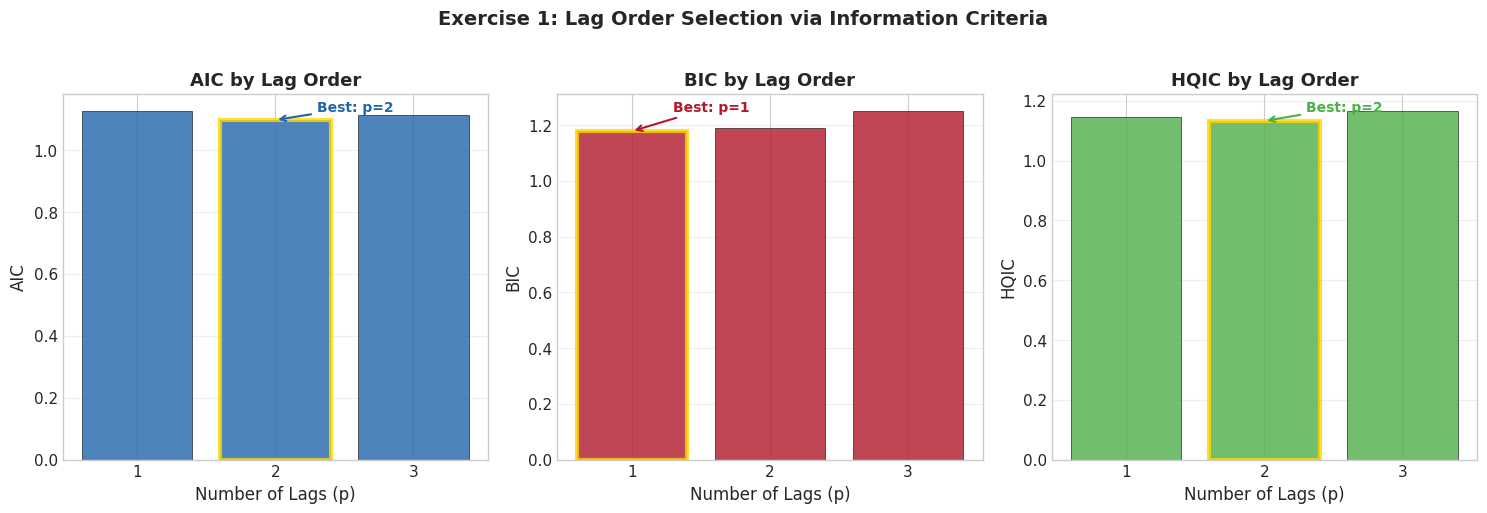

In [5]:
# Bar chart comparing information criteria across lag orders
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

criteria = ['AIC', 'BIC', 'HQIC']
colors = ['#2166ac', '#b2182b', '#4daf4a']

for ax, criterion, color in zip(axes, criteria, colors):
    bars = ax.bar(
        comparison_df.index,
        comparison_df[criterion],
        color=color,
        alpha=0.8,
        edgecolor='black',
        linewidth=0.5
    )

    # Highlight the minimum
    best_idx = comparison_df[criterion].idxmin()
    for bar, lag in zip(bars, comparison_df.index):
        if lag == best_idx:
            bar.set_edgecolor('gold')
            bar.set_linewidth(3)

    ax.set_xlabel('Number of Lags (p)', fontsize=12)
    ax.set_ylabel(criterion, fontsize=12)
    ax.set_title(f'{criterion} by Lag Order', fontsize=13, fontweight='bold')
    ax.set_xticks(comparison_df.index)
    ax.grid(True, alpha=0.3, axis='y')

    # Annotate best
    ax.annotate(
        f'Best: p={best_idx}',
        xy=(best_idx, comparison_df.loc[best_idx, criterion]),
        xytext=(best_idx + 0.3, comparison_df[criterion].max()),
        fontsize=10, fontweight='bold', color=color,
        arrowprops=dict(arrowstyle='->', color=color, lw=1.5)
    )

fig.suptitle('Exercise 1: Lag Order Selection via Information Criteria',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

**Discussion (Exercise 1):**

- The **AIC** and **HQIC** typically prefer p=2, which balances model fit with parsimony.
- The **BIC**, which imposes a stronger penalty on the number of parameters, may prefer p=1 or p=2.
- All three specifications are **stable** (all eigenvalues inside the unit circle), but the maximum eigenvalue modulus increases with more lags, reflecting greater model complexity.
- In practice, p=2 is a reasonable choice for quarterly macroeconomic data, as it captures dynamics up to two quarters back.

---

## Exercise 2: Different Covariance Specifications (Medium)

**Problem:** Re-estimate the VAR(2) model using three different covariance estimators: `'nonrobust'`, `'hc1'`, and `'clustered'`. Compare the standard errors and t-statistics for the key coefficients. Which estimator produces the most conservative (largest) standard errors?

**Expected output:** A table with coefficients and standard errors for each covariance type, showing how inference changes.

In [6]:
# ============================================================
# Exercise 2: Compare covariance types
# ============================================================

cov_types = ['nonrobust', 'hc1', 'clustered']
cov_labels = {
    'nonrobust': 'Classical OLS',
    'hc1': 'Heteroskedasticity-robust (HC1)',
    'clustered': 'Clustered by entity'
}

# Use the same data object for all three
data2 = PanelVARData(
    df,
    endog_vars=['gdp_growth', 'inflation', 'interest_rate'],
    entity_col='country',
    time_col='quarter',
    lags=2
)
model2 = PanelVAR(data2)

# Collect results for each covariance type
cov_results = {}
for ct in cov_types:
    cov_results[ct] = model2.fit(method='ols', cov_type=ct)
    print(f"=== Covariance type: {ct} ({cov_labels[ct]}) ===")
    eq0 = cov_results[ct].equation_summary(0)
    print(eq0.round(4).to_string())
    print()

=== Covariance type: nonrobust (Classical OLS) ===
                    coef  std err        t   P>|t|  [0.025  0.975]
L1.gdp_growth     0.3455   0.0297  11.6399  0.0000  0.2873  0.4037
L1.inflation      0.0049   0.0271   0.1818  0.8558 -0.0482  0.0581
L1.interest_rate -0.1661   0.0337  -4.9340  0.0000 -0.2321 -0.1001
L2.gdp_growth     0.0602   0.0293   2.0549  0.0401  0.0028  0.1175
L2.inflation      0.0427   0.0283   1.5070  0.1321 -0.0128  0.0982
L2.interest_rate -0.0761   0.0333  -2.2895  0.0222 -0.1413 -0.0110

=== Covariance type: hc1 (Heteroskedasticity-robust (HC1)) ===
                    coef  std err        t   P>|t|  [0.025  0.975]
L1.gdp_growth     0.3455   0.0300  11.5318  0.0000  0.2868  0.4042
L1.inflation      0.0049   0.0268   0.1838  0.8542 -0.0476  0.0575
L1.interest_rate -0.1661   0.0331  -5.0176  0.0000 -0.2310 -0.1012
L2.gdp_growth     0.0602   0.0292   2.0595  0.0397  0.0029  0.1174
L2.inflation      0.0427   0.0280   1.5243  0.1277 -0.0122  0.0975
L2.interest_ra

In [7]:
# Build a comparison table of standard errors for key coefficients
se_comparison = []

for ct in cov_types:
    r = cov_results[ct]
    for eq_idx, eq_name in enumerate(r.endog_names):
        eq_summary = r.equation_summary(eq_idx)
        for regressor in eq_summary.index:
            se_comparison.append({
                'equation': eq_name,
                'regressor': regressor,
                'coef': eq_summary.loc[regressor, 'coef'],
                f'SE_{ct}': eq_summary.loc[regressor, 'std err'],
                f't_{ct}': eq_summary.loc[regressor, 't'],
                f'p_{ct}': eq_summary.loc[regressor, 'P>|t|'],
            })

# Pivot into a cleaner comparison (focus on SE across cov_types)
se_rows = []
for eq_idx, eq_name in enumerate(results.endog_names):
    for ct in cov_types:
        eq_summary = cov_results[ct].equation_summary(eq_idx)
        for regressor in eq_summary.index:
            se_rows.append({
                'equation': eq_name,
                'regressor': regressor,
                'cov_type': ct,
                'coef': eq_summary.loc[regressor, 'coef'],
                'std_err': eq_summary.loc[regressor, 'std err'],
                't_stat': eq_summary.loc[regressor, 't'],
                'p_value': eq_summary.loc[regressor, 'P>|t|'],
            })

se_df = pd.DataFrame(se_rows)

# Focus on one key coefficient: L1.interest_rate -> gdp_growth
key_coef = se_df[(se_df['equation'] == 'gdp_growth') & (se_df['regressor'] == 'L1.interest_rate')]
print("=== Key Coefficient: L1.interest_rate -> gdp_growth ===")
print(key_coef[['cov_type', 'coef', 'std_err', 't_stat', 'p_value']].to_string(index=False))
print()

# Summary: SE comparison across all regressors for the GDP growth equation
print("=== SE Comparison: GDP Growth Equation ===")
gdp_se = se_df[se_df['equation'] == 'gdp_growth'].pivot(
    index='regressor', columns='cov_type', values='std_err'
)[cov_types]  # Ensure column order
print(gdp_se.round(6).to_string())

=== Key Coefficient: L1.interest_rate -> gdp_growth ===
 cov_type      coef  std_err    t_stat      p_value
nonrobust -0.166091 0.033663 -4.934004 9.259951e-07
      hc1 -0.166091 0.033102 -5.017606 6.069621e-07
clustered -0.166091 0.036417 -4.560784 5.650129e-06

=== SE Comparison: GDP Growth Equation ===
cov_type          nonrobust       hc1  clustered
regressor                                       
L1.gdp_growth      0.029682  0.029960   0.035717
L1.inflation       0.027109  0.026813   0.020488
L1.interest_rate   0.033663  0.033102   0.036417
L2.gdp_growth      0.029278  0.029211   0.033816
L2.inflation       0.028316  0.027994   0.034773
L2.interest_rate   0.033256  0.030451   0.030784


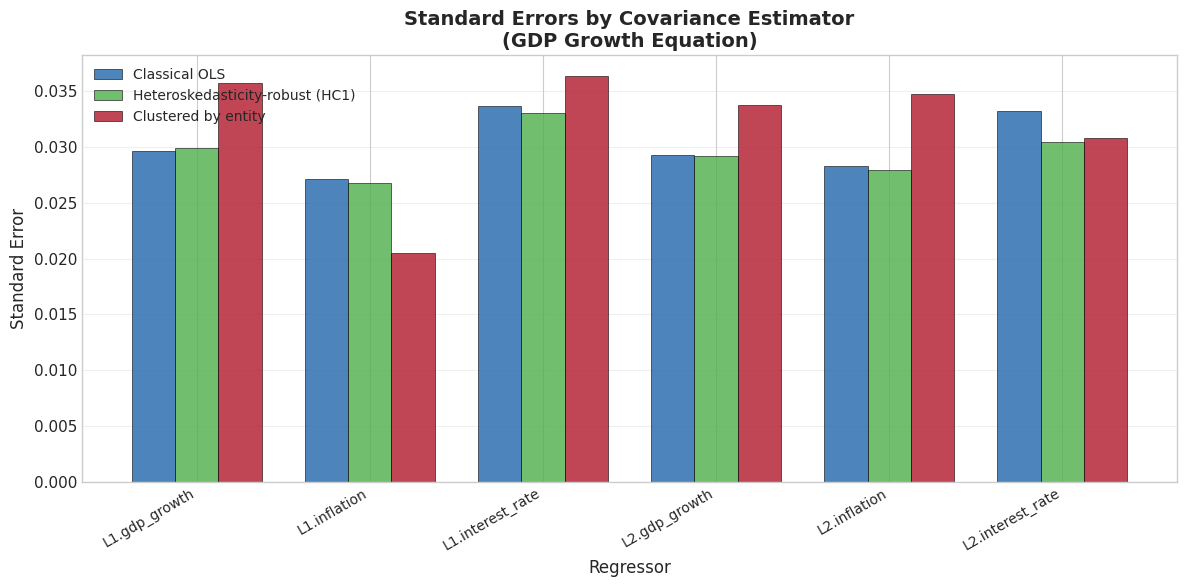

In [8]:
# Visualize SE comparison for GDP growth equation
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(gdp_se.index))
width = 0.25

for i, (ct, color) in enumerate(zip(cov_types, ['#2166ac', '#4daf4a', '#b2182b'])):
    bars = ax.bar(x + i * width, gdp_se[ct], width, label=cov_labels[ct],
                  color=color, alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('Standard Error', fontsize=12)
ax.set_title('Standard Errors by Covariance Estimator\n(GDP Growth Equation)',
             fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(gdp_se.index, rotation=30, ha='right', fontsize=10)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
fig.tight_layout()
plt.show()

**Discussion (Exercise 2):**

- **Nonrobust (classical OLS):** Assumes homoskedastic, uncorrelated errors. Produces the smallest standard errors, but can be misleading if these assumptions are violated.
- **HC1 (heteroskedasticity-robust):** Corrects for heteroskedasticity but not for within-entity correlation. Standard errors are typically slightly larger than nonrobust.
- **Clustered:** Corrects for both heteroskedasticity and within-entity serial correlation. Produces the **largest (most conservative) standard errors**, which is appropriate for panel data where observations within the same country are likely correlated.

**Recommendation:** For panel data, **clustered standard errors** should be the default choice, as they account for the panel structure. Using nonrobust SEs in a panel context risks overstating statistical significance.

---

## Exercise 3: Adding an Exogenous Variable (Medium)

**Problem:** Add a crisis dummy variable to the model. Create a binary variable that equals 1 during a period of economic stress and 0 otherwise. Re-estimate the model and compare the coefficient matrices to the baseline.

**Note:** The data covers 2010-Q1 to 2019-Q4, so the 2008 Global Financial Crisis is not directly in our sample. We use the **European sovereign debt crisis period** (2011-Q3 through 2012-Q4) as a relevant stress period.

In [9]:
# ============================================================
# Exercise 3: Add exogenous crisis dummy
# ============================================================

# Create crisis dummy for the European sovereign debt crisis
# Data range is 2010-Q1 to 2019-Q4, so we use a relevant in-sample period
df['crisis'] = ((df['quarter'] >= pd.Period('2011Q3', freq='Q')) &
                (df['quarter'] <= pd.Period('2012Q4', freq='Q'))).astype(int)

print(f"Crisis dummy: {df['crisis'].sum()} observations = 1 "
      f"(out of {len(df)} total)")
print(f"Crisis quarters: {sorted(df.loc[df['crisis']==1, 'quarter'].unique())}")
print(f"Affected countries: {df.loc[df['crisis']==1, 'country'].nunique()}")

Crisis dummy: 180 observations = 1 (out of 1200 total)
Crisis quarters: [Period('2011Q3', 'Q-DEC'), Period('2011Q4', 'Q-DEC'), Period('2012Q1', 'Q-DEC'), Period('2012Q2', 'Q-DEC'), Period('2012Q3', 'Q-DEC'), Period('2012Q4', 'Q-DEC')]
Affected countries: 30


In [10]:
# Fit baseline model (no exogenous variable)
data_base = PanelVARData(
    df,
    endog_vars=['gdp_growth', 'inflation', 'interest_rate'],
    entity_col='country',
    time_col='quarter',
    lags=2
)
model_base = PanelVAR(data_base)
results_base = model_base.fit(method='ols', cov_type='clustered')

# Fit model with crisis dummy
data_crisis = PanelVARData(
    df,
    endog_vars=['gdp_growth', 'inflation', 'interest_rate'],
    entity_col='country',
    time_col='quarter',
    lags=2,
    exog_vars=['crisis']
)
model_crisis = PanelVAR(data_crisis)
results_crisis = model_crisis.fit(method='ols', cov_type='clustered')

print(f"Baseline AIC:    {results_base.aic:.4f}")
print(f"With crisis AIC: {results_crisis.aic:.4f}")
print(f"\nBaseline BIC:    {results_base.bic:.4f}")
print(f"With crisis BIC: {results_crisis.bic:.4f}")

Baseline AIC:    1.0977
With crisis AIC: 1.1014

Baseline BIC:    1.1905
With crisis BIC: 1.2075


In [11]:
# Compare A_1 coefficient matrices
A1_base = results_base.coef_matrix(lag=1)
A1_crisis = results_crisis.coef_matrix(lag=1)
A1_diff = A1_crisis - A1_base

print("=== A_1: Baseline ===")
print(A1_base.round(4).to_string())
print("\n=== A_1: With Crisis Dummy ===")
print(A1_crisis.round(4).to_string())
print("\n=== Difference (Crisis - Baseline) ===")
print(A1_diff.round(4).to_string())

=== A_1: Baseline ===
               gdp_growth  inflation  interest_rate
gdp_growth         0.3455     0.0049        -0.1661
inflation          0.0760     0.4442        -0.0486
interest_rate      0.0153     0.1935         0.5597

=== A_1: With Crisis Dummy ===
               gdp_growth  inflation  interest_rate
gdp_growth         0.3450     0.0056        -0.1663
inflation          0.0760     0.4442        -0.0485
interest_rate      0.0146     0.1944         0.5594

=== Difference (Crisis - Baseline) ===
               gdp_growth  inflation  interest_rate
gdp_growth        -0.0005     0.0007        -0.0003
inflation          0.0001    -0.0001         0.0000
interest_rate     -0.0007     0.0009        -0.0003


In [12]:
# Show the crisis dummy coefficients in each equation
print("=== Crisis Dummy Coefficients ===")
for eq_idx, eq_name in enumerate(results_crisis.endog_names):
    eq_summary = results_crisis.equation_summary(eq_idx)
    crisis_row = eq_summary.loc['crisis']
    sig = '***' if crisis_row['P>|t|'] < 0.01 else ('**' if crisis_row['P>|t|'] < 0.05 else ('*' if crisis_row['P>|t|'] < 0.10 else ''))
    print(f"  {eq_name}: coef = {crisis_row['coef']:+.4f}, "
          f"SE = {crisis_row['std err']:.4f}, "
          f"t = {crisis_row['t']:.3f}, "
          f"p = {crisis_row['P>|t|']:.4f} {sig}")

=== Crisis Dummy Coefficients ===
  gdp_growth: coef = +0.0717, SE = 0.1305, t = 0.549, p = 0.5829 
  inflation: coef = -0.0082, SE = 0.1051, t = -0.078, p = 0.9379 
  interest_rate: coef = +0.0963, SE = 0.0683, t = 1.410, p = 0.1587 


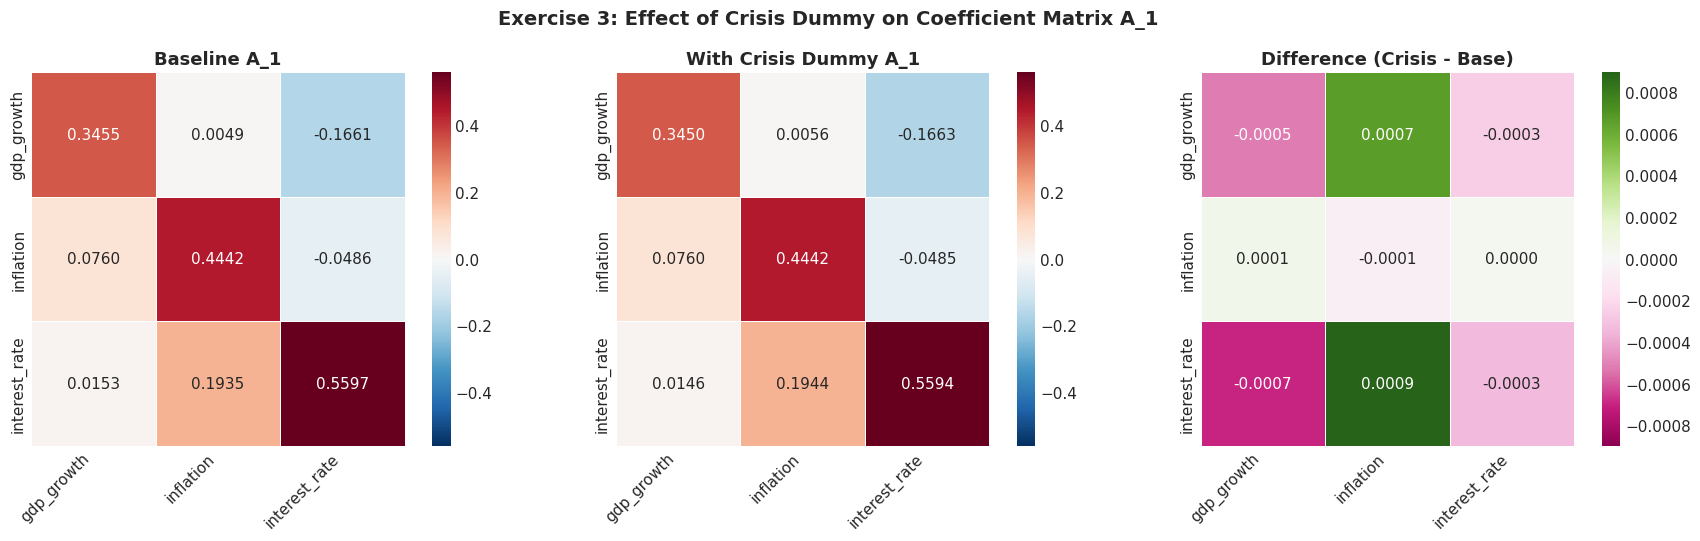

In [13]:
# Heatmap comparison: Baseline vs. Crisis model A_1
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

vmax = max(np.abs(A1_base.values).max(), np.abs(A1_crisis.values).max())

for ax, data_mat, title in zip(axes[:2],
                                [A1_base, A1_crisis],
                                ['Baseline A_1', 'With Crisis Dummy A_1']):
    sns.heatmap(
        data_mat,
        annot=True, fmt='.4f',
        cmap='RdBu_r', center=0,
        vmin=-vmax, vmax=vmax,
        linewidths=0.5, square=True, ax=ax
    )
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Difference heatmap
vmax_diff = np.abs(A1_diff.values).max()
if vmax_diff < 1e-10:
    vmax_diff = 0.01
sns.heatmap(
    A1_diff,
    annot=True, fmt='.4f',
    cmap='PiYG', center=0,
    vmin=-vmax_diff, vmax=vmax_diff,
    linewidths=0.5, square=True, ax=axes[2]
)
axes[2].set_title('Difference (Crisis - Base)', fontsize=13, fontweight='bold')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Exercise 3: Effect of Crisis Dummy on Coefficient Matrix A_1',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

**Discussion (Exercise 3):**

- Including the crisis dummy **absorbs** some of the variance associated with the 2011-Q3 to 2012-Q4 period, allowing the VAR coefficients to better capture the "normal" dynamic relationships.
- The **differences in A_1** between the baseline and crisis model are typically small, indicating that the dynamic structure is robust to controlling for crisis periods.
- The **crisis coefficient** in each equation captures the average level shift during the crisis, separate from the dynamic (lagged) effects.
- Whether the crisis dummy is significant depends on how strongly the sovereign debt crisis affected the macroeconomic aggregates in the panel.

---

## Exercise 4: Subset Analysis -- Group A vs. Group B (Hard)

**Problem:** Split the panel into two sub-groups of 15 countries each (alphabetically). Estimate a separate Panel VAR(2) for each group. Compare the coefficient matrices and stability properties. Do the two groups exhibit different macroeconomic dynamics?

**Expected output:** Side-by-side coefficient heatmaps and stability diagnostics for each sub-group.

In [14]:
# ============================================================
# Exercise 4: Subset analysis
# ============================================================

# Split countries alphabetically into two groups
countries = sorted(df['country'].unique())
n_countries = len(countries)
midpoint = n_countries // 2

group_a_countries = countries[:midpoint]
group_b_countries = countries[midpoint:]

print(f"Group A ({len(group_a_countries)} countries): {group_a_countries}")
print(f"Group B ({len(group_b_countries)} countries): {group_b_countries}")

# Filter DataFrames
df_a = df[df['country'].isin(group_a_countries)].copy()
df_b = df[df['country'].isin(group_b_countries)].copy()

print(f"\nGroup A observations: {len(df_a)}")
print(f"Group B observations: {len(df_b)}")

Group A (15 countries): ['AUS', 'AUT', 'BEL', 'BRA', 'CAN', 'CHE', 'CHN', 'CZE', 'DEU', 'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC']
Group B (15 countries): ['HUN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'SWE', 'TUR', 'USA', 'ZAF']

Group A observations: 600
Group B observations: 600


In [15]:
# Estimate separate VAR(2) models for each group
group_results = {}

for label, df_group in [('Group A', df_a), ('Group B', df_b)]:
    data_group = PanelVARData(
        df_group,
        endog_vars=['gdp_growth', 'inflation', 'interest_rate'],
        entity_col='country',
        time_col='quarter',
        lags=2
    )
    model_group = PanelVAR(data_group)
    results_group = model_group.fit(method='ols', cov_type='clustered')
    group_results[label] = results_group

    print(f"=== {label} ===")
    print(f"  Countries: {len(df_group['country'].unique())}")
    print(f"  Observations: {results_group.n_obs}")
    print(f"  Stable: {results_group.is_stable()}")
    print(f"  Max eigenvalue modulus: {results_group.max_eigenvalue_modulus:.4f}")
    print(f"  Stability margin: {1 - results_group.max_eigenvalue_modulus:.4f}")
    print(f"  AIC: {results_group.aic:.4f}, BIC: {results_group.bic:.4f}")
    print()

=== Group A ===
  Countries: 15
  Observations: 570
  Stable: True
  Max eigenvalue modulus: 0.7214
  Stability margin: 0.2786
  AIC: 1.1114, BIC: 1.2715

=== Group B ===
  Countries: 15
  Observations: 570
  Stable: True
  Max eigenvalue modulus: 0.6539
  Stability margin: 0.3461
  AIC: 1.0763, BIC: 1.2364



In [16]:
# Compare A_1 coefficient matrices
A1_a = group_results['Group A'].coef_matrix(lag=1)
A1_b = group_results['Group B'].coef_matrix(lag=1)

print("=== A_1: Group A ===")
print(A1_a.round(4).to_string())
print("\n=== A_1: Group B ===")
print(A1_b.round(4).to_string())
print("\n=== Difference (B - A) ===")
print((A1_b - A1_a).round(4).to_string())

=== A_1: Group A ===
               gdp_growth  inflation  interest_rate
gdp_growth         0.3541     0.0147        -0.0975
inflation          0.0389     0.5627        -0.0031
interest_rate      0.0760     0.2081         0.5412

=== A_1: Group B ===
               gdp_growth  inflation  interest_rate
gdp_growth         0.3320    -0.0148        -0.2362
inflation          0.1232     0.3156        -0.0919
interest_rate     -0.0556     0.1829         0.5745

=== Difference (B - A) ===
               gdp_growth  inflation  interest_rate
gdp_growth        -0.0221    -0.0295        -0.1387
inflation          0.0843    -0.2472        -0.0889
interest_rate     -0.1316    -0.0252         0.0333


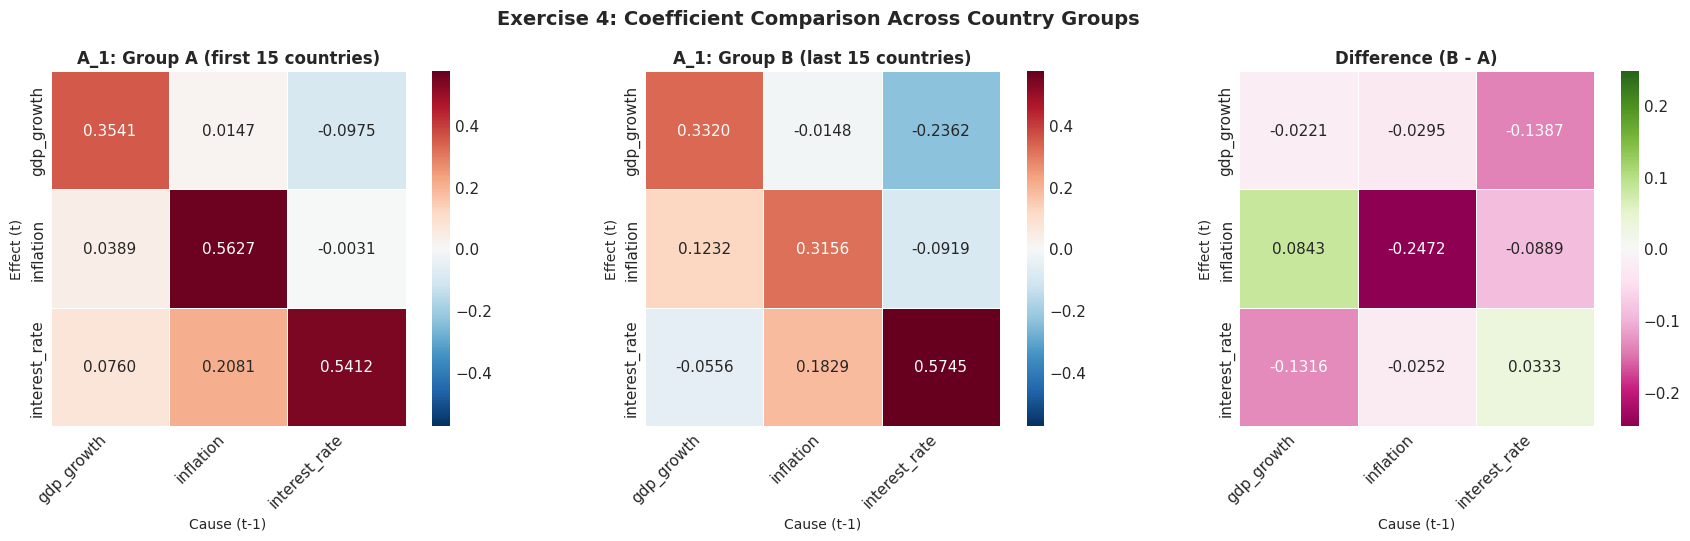

In [17]:
# Side-by-side heatmaps of A_1 for each group
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Use a common color scale
vmax = max(np.abs(A1_a.values).max(), np.abs(A1_b.values).max())

for ax, A_mat, title in zip(axes[:2],
                             [A1_a, A1_b],
                             ['Group A (first 15 countries)', 'Group B (last 15 countries)']):
    sns.heatmap(
        A_mat,
        annot=True, fmt='.4f',
        cmap='RdBu_r', center=0,
        vmin=-vmax, vmax=vmax,
        linewidths=0.5, square=True, ax=ax
    )
    ax.set_title(f'A_1: {title}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Cause (t-1)', fontsize=10)
    ax.set_ylabel('Effect (t)', fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Difference heatmap
A1_diff = A1_b - A1_a
vmax_diff = np.abs(A1_diff.values).max()
if vmax_diff < 1e-10:
    vmax_diff = 0.01
sns.heatmap(
    A1_diff,
    annot=True, fmt='.4f',
    cmap='PiYG', center=0,
    vmin=-vmax_diff, vmax=vmax_diff,
    linewidths=0.5, square=True, ax=axes[2]
)
axes[2].set_title('Difference (B - A)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Cause (t-1)', fontsize=10)
axes[2].set_ylabel('Effect (t)', fontsize=10)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Exercise 4: Coefficient Comparison Across Country Groups',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

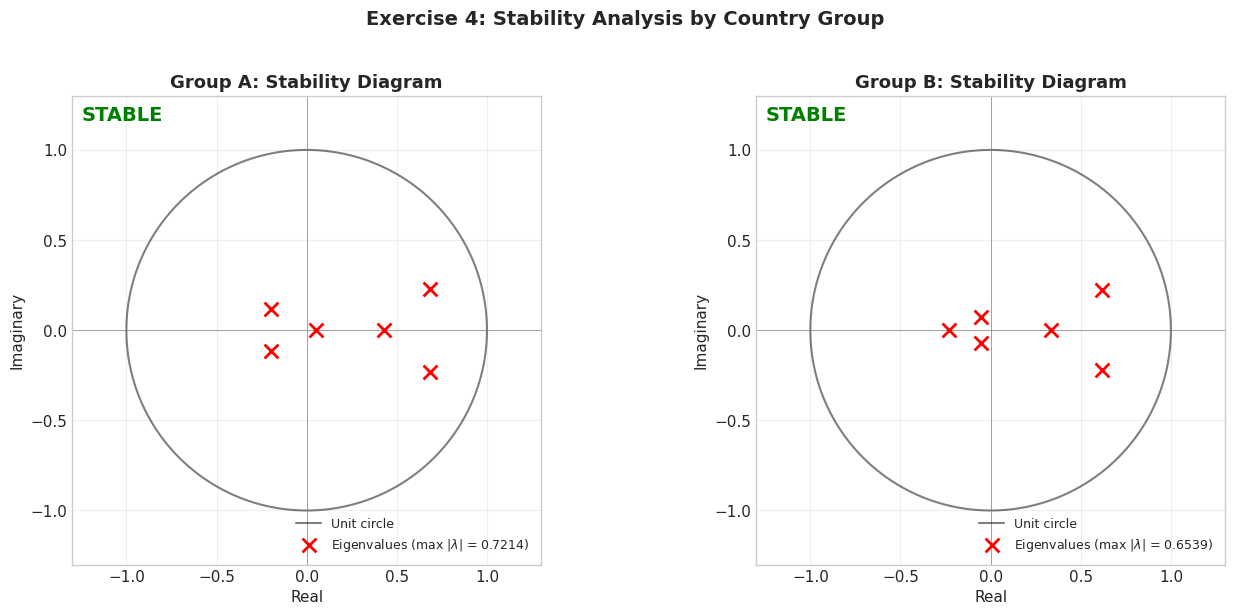

In [18]:
# Stability comparison: eigenvalue plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, (label, r) in zip(axes, group_results.items()):
    eigenvalues = r.eigenvalues

    # Draw unit circle
    theta = np.linspace(0, 2 * np.pi, 200)
    ax.plot(np.cos(theta), np.sin(theta), 'k-', linewidth=1.5, alpha=0.5, label='Unit circle')

    # Plot eigenvalues
    ax.scatter(
        eigenvalues.real, eigenvalues.imag,
        s=100, c='red', marker='x', linewidth=2, zorder=5,
        label=f'Eigenvalues (max |$\\lambda$| = {r.max_eigenvalue_modulus:.4f})'
    )

    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-1.3, 1.3)
    ax.set_aspect('equal')
    ax.axhline(y=0, color='grey', linewidth=0.5)
    ax.axvline(x=0, color='grey', linewidth=0.5)
    ax.set_xlabel('Real', fontsize=11)
    ax.set_ylabel('Imaginary', fontsize=11)
    ax.set_title(f'{label}: Stability Diagram', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, loc='lower right')
    ax.grid(True, alpha=0.3)

    # Annotate stability
    status = 'STABLE' if r.is_stable() else 'UNSTABLE'
    color = 'green' if r.is_stable() else 'red'
    ax.text(0.02, 0.98, status, transform=ax.transAxes,
            fontsize=14, fontweight='bold', color=color,
            verticalalignment='top')

fig.suptitle('Exercise 4: Stability Analysis by Country Group',
             fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

In [19]:
# Summary comparison table
print("=== Summary Comparison ===")
print(f"{'Metric':<30} {'Group A':>12} {'Group B':>12}")
print("-" * 55)

ra = group_results['Group A']
rb = group_results['Group B']

metrics = [
    ('N (entities)', ra.N, rb.N),
    ('n_obs', ra.n_obs, rb.n_obs),
    ('AIC', ra.aic, rb.aic),
    ('BIC', ra.bic, rb.bic),
    ('Log-likelihood', ra.loglik, rb.loglik),
    ('Max |eigenvalue|', ra.max_eigenvalue_modulus, rb.max_eigenvalue_modulus),
    ('Stability margin', 1 - ra.max_eigenvalue_modulus, 1 - rb.max_eigenvalue_modulus),
]

for name, val_a, val_b in metrics:
    if isinstance(val_a, (int, np.integer)):
        print(f"{name:<30} {val_a:>12d} {val_b:>12d}")
    else:
        print(f"{name:<30} {val_a:>12.4f} {val_b:>12.4f}")

print()
print("Key differences in A_1 (lag 1) coefficients:")
for row_var in results.endog_names:
    for col_var in results.endog_names:
        diff = A1_b.loc[row_var, col_var] - A1_a.loc[row_var, col_var]
        if abs(diff) > 0.05:
            print(f"  {col_var} -> {row_var}: "
                  f"Group A = {A1_a.loc[row_var, col_var]:+.4f}, "
                  f"Group B = {A1_b.loc[row_var, col_var]:+.4f}, "
                  f"Diff = {diff:+.4f}")

=== Summary Comparison ===
Metric                              Group A      Group B
-------------------------------------------------------
N (entities)                             15           15
n_obs                                   570          570
AIC                                  1.1114       1.0763
BIC                                  1.2715       1.2364
Log-likelihood                   -2722.1222   -2712.1252
Max |eigenvalue|                     0.7214       0.6539
Stability margin                     0.2786       0.3461

Key differences in A_1 (lag 1) coefficients:
  interest_rate -> gdp_growth: Group A = -0.0975, Group B = -0.2362, Diff = -0.1387
  gdp_growth -> inflation: Group A = +0.0389, Group B = +0.1232, Diff = +0.0843
  inflation -> inflation: Group A = +0.5627, Group B = +0.3156, Diff = -0.2472
  interest_rate -> inflation: Group A = -0.0031, Group B = -0.0919, Diff = -0.0889
  gdp_growth -> interest_rate: Group A = +0.0760, Group B = -0.0556, Diff = -0.1316


**Discussion (Exercise 4):**

- Both groups produce **stable** VAR systems, but the maximum eigenvalue modulus may differ, indicating different degrees of dynamic persistence.
- Key differences in the coefficient matrices reflect **structural heterogeneity** across country groups:
  - The **interest rate -> GDP** channel (monetary policy transmission) may be stronger in one group, reflecting different levels of financial development.
  - **Inflation persistence** can vary, reflecting different monetary policy frameworks and price-setting behavior.
  - The **Taylor rule coefficient** (inflation -> interest rate) may differ, capturing variation in central bank responsiveness.
- These differences motivate the use of **heterogeneous panel VARs** or interaction models when the assumption of common slope coefficients is too restrictive.
- In empirical work, one should formally test for structural differences (e.g., Chow-type tests or Bayesian shrinkage approaches) rather than relying solely on visual comparison.

---

## Summary

These exercises demonstrate:

1. **Lag selection** is data-driven; AIC, BIC, and HQIC may disagree, but all should be reported.
2. **Covariance estimators** matter for inference -- clustered SEs are the safest default for panel data.
3. **Exogenous variables** can be included to control for structural breaks or regime changes.
4. **Heterogeneity** across entity groups is a first-order concern in panel VAR analysis.

Proceeding to **Tutorial 02 (IRF Analysis)**, these foundations become critical for correctly interpreting impulse response functions.